## DATA 620 - Project 1

---

### Mael Illien, Jeremy OBrien & Vanita Thompson

* Identify and load a network dataset that has some categorical information available for each node.
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
* Compare your centrality measures across your categorical groups.
* For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes. You might use a t-test or another statistical measure to support your findings.


## Introduction

As detailed in our [Assignment 2 submission](https://github.com/JeremyOBrien16/CUNY_DATA_620/blob/master/Assignment02/data620assignment2.ipynb), for this project we've sourced venue visitation data for NYC locations via Foursquare's [Places API](https://developer.foursquare.com/docs/places-api/). 

Due to a recurring API call issue (call error limits inconsistent with Foursquare's own documentation) our access to the data was irregular, requiring us to rework our data import protocol. Our original plan was to select three venues of interest as starting nodes and then crawl a network of venues user typically visit subsequently (using Fousquare's nextvenues endpoint in order to establish links and chart a graph). While API calls routinely failed following their initial, successful setup, we were able to salvage the links between venues and save them to csv files. Accordingly, we start the project by importing the link data contained in the csv files.

In order to generate a graph that could span multiple NYC neighborhoods, we chose the following venues as starting points:
- Empire State Building (midtown)
- One World Observatory (downtown) 
- Washington Square Park (the Village). 

After composing the graph, we calculated some centrality measures across a categorical variable called 'categories' which reflects the type of venue. From these measures, we performed some statistical tests to investigate whether ventrality measures differed across venue category.

## Setup

In [1]:
import csv
import foursquare
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from config import foursquare_config as fs_config
from IPython.display import display, HTML
%matplotlib inline

## Data Import

We import the data from CSV source files prepared based on successful Foursquare API calls for the three venues.

In [2]:
# Source files capturing API call results
midtown_raw = pd.read_csv('venues_midtown_unique.csv')
downtown_raw = pd.read_csv('venues_downtown.csv')
westvil_raw = pd.read_csv('venues_westvil_unique.csv')

In [3]:
# Clean up datasets
midtown = midtown_raw.filter(items=['id', 'name','type'])
downtown = downtown_raw.drop_duplicates()
downtown = downtown.filter(items=['id', 'name','type'])
westvil = westvil_raw.filter(items=['id', 'name','type'])

In [4]:
# Combine the three venue dataframes into one
venues = midtown
venues = venues.append(westvil, ignore_index=True)
venues = venues.append(downtown, ignore_index=True)
venues = venues.drop_duplicates()
venues = venues.reset_index(drop=True)

print("Working with {} venues".format(len(venues)))
venues.head()

Working with 65 venues


,id,name,type
0,43695300f964a5208c291fe3,Empire State Building,Building
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout
2,49b7ed6df964a52030531fe3,Times Square,Plaza
3,41102700f964a520d60b1fe3,Macy's,Department Store
4,40b68100f964a5207d001fe3,Madison Square Park,Park


## Data Processing

We consolidate venue categories to facilitate downstream analysis.

In [5]:
venues['category'] = None

# Grouping venues types into larger categories
foods = ['Food Court','Theme Restaurant','Burgers','Gourmet',"Farmer's Market", 'Coffee Shop', 'Falafel', 
         'Beer Garden','Pizza','Food Court', 'Grocery Store', 'New American','American']
shops = ['Department Store', 'Candy Store', 'Toys & Games', 'Bookstore','Market','Electronics','Cosmetics',
         'Wine Shop','Comic Shop','Mall']
entertainment = ['Basketball','Indie Movies','Performing Arts','Art Museum','Movie Theater','Dog Run']
tourist = ['Building','Scenic Lookout','Plaza','Park','Fountain','Outdoor Sculpture',' Memorial Site',
           'Bridge','Landmark','Historic Site','Island','Memorial Site']

for i in range(len(venues)):
    venue_type = venues['type'][i]
    if venue_type in foods:
        venues['category'][i] = 'Food and Beverage'
    elif venue_type in shops:
        venues['category'][i] = 'Shopping'
    elif venue_type in entertainment:
        venues['category'][i] = 'Entertainment'
    elif venue_type in tourist:
        venues['category'][i] = 'Tourist Attraction'
    else:
        venues['category'][i] = 'Other'      

In [6]:
display(HTML(venues.head().to_html(index=False)))

id,name,type,category
43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction
4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout,Tourist Attraction
49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction
41102700f964a520d60b1fe3,Macy's,Department Store,Shopping
40b68100f964a5207d001fe3,Madison Square Park,Park,Tourist Attraction


## Generate network

To generate the network, we read and append the links contained in csv files for each of the neighborhoods of interest. We use these links to generate edges. We also iterate over the nodes to enter their attributes.

In [7]:
def generate_network(venues, link_files):
    # Read links from file which are stored as a str representation of tuples
    links = []
    for lf in link_files:
        with open(lf, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                as_tpl = eval(row[0])
                links.append(as_tpl)
    
    # Create graph
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
        
    # Add attributes to the nodes
    for i in range(len(venues)):
        ven_id = venues['id'][i]
        G.nodes[ven_id]['name'] = venues['name'][i]
        G.nodes[ven_id]['category'] = venues['category'][i]
        
    return G

The returned graph contains an unexpected number of nodes. This is a due to the inclusion of target venues (i.e. venues visited subsequent to a source venue) that API calls failed for, preventing us from acquiring visitation data.  As these nodes lack names and attributes, we remove them. This restores the graph to its expected size, consequently raising the average degree of the network.

In [8]:
# Graph including nodes without names or attributes
link_files = ['links_midtown.csv','links_westvil.csv','links_downtown.csv']
g = generate_network(venues, link_files)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 107
Number of edges: 245
Average in degree:   2.2897
Average out degree:   2.2897


In [9]:
# Identify and drop nodes that have no info
no_name = [node for node in g.nodes if node not in list(venues['id'])]
g.remove_nodes_from(no_name)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 65
Number of edges: 199
Average in degree:   3.0615
Average out degree:   3.0615


## Compute metrics

We compute centrality measures of the graph and analyze it on the basis of venue categories.

In [10]:
def get_metrics(venues, graph):

    degree = nx.degree(graph)
    venues['degree'] = [degree[n] for n in venues['id']]
    pagerank = nx.pagerank(graph, alpha=.9)
    venues['pagerank'] = [pagerank[n] for n in venues['id']]
    betweenness = nx.betweenness_centrality(graph)
    venues['betweenness'] = [betweenness[n] for n in venues['id']]
    closeness = nx.closeness_centrality(graph)
    venues['closeness'] = [closeness[n] for n in venues['id']]
    
    return venues

In [11]:
metrics = get_metrics(venues, g)

The below dataframes contain the top five venues for each metric sorted in descending order regardless of category. 

#### Table 1: Top 5 venues by degree

Tourist hotspots like Times Square, the 9/11 museum, and midtown parks are connected to many others in visit patterns.

In [12]:
display(HTML(metrics.sort_values(by=['degree'], ascending=False).head().to_html(index=False)))

id,name,type,category,degree,pagerank,betweenness,closeness
49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (National September 11 Memorial),Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
4abe7f9ef964a520068e20e3,One World Trade Center,Building,Tourist Attraction,15,0.036169,0.076209,0.191406
3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898


#### Table 2: Top 5 venues by pagerank

Brooklyn Bridge and Rockefeller Center edge out One World Trade and Union Square Park when the connections of neighbors are taken into account.

In [13]:
display(HTML(metrics.sort_values(by=['pagerank'], ascending=False).head().to_html(index=False)))

id,name,type,category,degree,pagerank,betweenness,closeness
49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (National September 11 Memorial),Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,Tourist Attraction,13,0.053154,0.173723,0.186233
3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
49b79f54f964a5202c531fe3,Rockefeller Center,Plaza,Tourist Attraction,6,0.045355,0.000000,0.184230


#### Table 3: Top 5 venues by betweenness

Several parks and bridges are found at the top of the list of venues found on itineraries with other starting points.

In [14]:
display(HTML(metrics.sort_values(by=['betweenness'], ascending=False).head().to_html(index=False)))

id,name,type,category,degree,pagerank,betweenness,closeness
4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,Tourist Attraction,13,0.053154,0.173723,0.186233
3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898
40abf500f964a52035f31ee3,Washington Square Park,Park,Tourist Attraction,11,0.014721,0.152679,0.211765
4a32c3f9f964a5208c9a1fe3,Manhattan Bridge,Bridge,Tourist Attraction,5,0.011933,0.148797,0.120888
43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction,12,0.024481,0.146280,0.198047


#### Table 4: Top 5 venues by closeness

Macy's finds its way into the top five when considering how directly connected venues are to one another.

In [15]:
display(HTML(metrics.sort_values(by=['closeness'], ascending=False).head().to_html(index=False)))

id,name,type,category,degree,pagerank,betweenness,closeness
49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898
4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (National September 11 Memorial),Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
41102700f964a520d60b1fe3,Macy's,Department Store,Shopping,11,0.015229,0.078633,0.212193


The function below generates the top 5 values and names for each of the centrality measure and for each category.

In [16]:
measures = ['degree','pagerank','betweenness','closeness']

def category_centrality(metrics, display='values'):
    dfh = pd.DataFrame()
    cat_centrality = pd.DataFrame()
    categories = list(set(metrics.category))

    for cat in categories:
        ven = metrics[metrics['category'] == cat]
        
        dfh['category'] = [cat]*5 
        
        for measure in measures:
            
            top_5 = ven.sort_values(by=[measure], ascending=False).head()
            top_5 = top_5.filter(items=['name',measure])
            
            if display == 'names':
                dfh[measure] = list(top_5['name'])
            else:
                dfh[measure] = list(top_5[measure])
            
        cat_centrality =  cat_centrality.append(dfh)
        
    return cat_centrality

#### Top 5 centrality measure values for each category 

In [17]:
with_vals = category_centrality(metrics)
display(HTML(with_vals.to_html(index=False)))

category,degree,pagerank,betweenness,closeness
Tourist Attraction,21,0.100207,0.173723,0.250164
Tourist Attraction,19,0.053557,0.161632,0.244898
Tourist Attraction,15,0.053154,0.152679,0.237608
Tourist Attraction,14,0.046678,0.148797,0.218033
Tourist Attraction,13,0.045355,0.146280,0.211765
Entertainment,4,0.016403,0.000620,0.158438
Entertainment,4,0.006327,0.000000,0.156969
Entertainment,2,0.005105,0.000000,0.146852
Entertainment,1,0.004513,0.000000,0.141568
Entertainment,1,0.004513,0.000000,0.141568


#### Top 5 centrality measure for each category with venue names

In [18]:
with_names = category_centrality(metrics,display='names')
display(HTML(with_names.to_html(index=False)))

category,degree,pagerank,betweenness,closeness
Tourist Attraction,Times Square,Times Square,Brooklyn Bridge,Times Square
Tourist Attraction,National September 11 Memorial & Museum (National September 11 Memorial),National September 11 Memorial & Museum (National September 11 Memorial),Union Square Park,Union Square Park
Tourist Attraction,One World Trade Center,Brooklyn Bridge,Washington Square Park,National September 11 Memorial & Museum (National September 11 Memorial)
Tourist Attraction,Bryant Park,Bryant Park,Manhattan Bridge,Bryant Park
Tourist Attraction,Union Square Park,Rockefeller Center,Empire State Building,Washington Square Park
Entertainment,Madison Square Garden,Regal Battery Park,Regal Battery Park,Madison Square Garden
Entertainment,Regal Battery Park,Regal Union Square ScreenX & 4DX,Madison Square Garden,Regal Union Square ScreenX & 4DX
Entertainment,Regal Union Square ScreenX & 4DX,Madison Square Garden,Washington Square Dog Run,Whitney Museum of American Art
Entertainment,Washington Square Dog Run,NYU Skirball Center for Performing Arts,Angelika Film Center,Angelika Film Center
Entertainment,Angelika Film Center,Angelika Film Center,NYU Skirball Center for Performing Arts,NYU Skirball Center for Performing Arts


One key takeaway from this analysis of centrality is that while Times Square is the most connected node by a variety of measures, the Brooklyn bridge has a higher measure of betweenness, meaning that more users pass through that node to reach the rest of the network.

## Statistical Test

We test whether these metrics are consistent between categorical groups - first, visually with the help of boxplots; and second, using ANOVA.

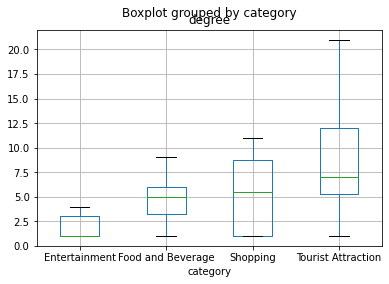

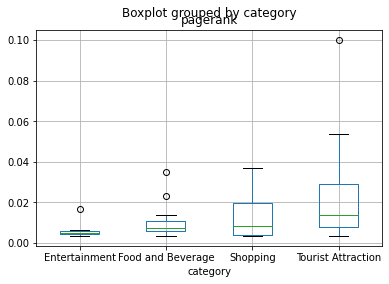

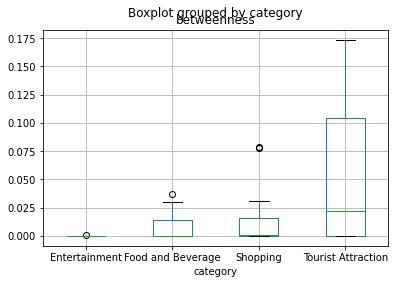

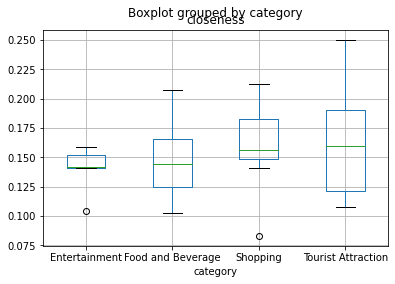

In [19]:
for measure in measures:
    metrics.boxplot(measure, by='category')

It is intuitive that the Tourist Attraction category has the largest distribution over the metrics, as venue data is more likely to be exploited by tourist looking to build an itinerary. We can also notice a significant outlier in pagerank which we can consider the most important node in the network. You might not be surprised that this particular node corresponds to Times Square.

#### Analysis of variance 

In [20]:
mod = ols('degree ~ category',data=metrics).fit()                
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA - Degree', '\n', aov_table)

ANOVA - Degree 
               sum_sq    df        F    PR(>F)
category  346.765079   3.0  7.71221  0.000189
Residual  914.250305  61.0      NaN       NaN


In [21]:
mod = ols('closeness ~ category',data=metrics).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA - Closeness', '\n', aov_table)

ANOVA - Closeness 
             sum_sq    df         F    PR(>F)
category  0.005444   3.0  1.413311  0.247533
Residual  0.078320  61.0       NaN       NaN


In [22]:
mod = ols('betweenness ~ category', data=metrics).fit()                
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA - Betweenness', '\n', aov_table)

ANOVA - Betweenness 
             sum_sq    df         F   PR(>F)
category  0.031497   3.0  5.892221  0.00134
Residual  0.108693  61.0       NaN      NaN


In [23]:
mod = ols('pagerank ~ category',data=metrics).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA - Pagerank', '\n', aov_table)

ANOVA - Pagerank 
             sum_sq    df         F    PR(>F)
category  0.002508   3.0  3.277602  0.026873
Residual  0.015561  61.0       NaN       NaN


The analysis of variance supports rejecting the null hypothesis - that the means of the centrality measures across categories are the same - for all measures but closeness. This is not surprising given the closeness boxplot above which had similar means. From this we can conclude that there is no significant difference in the closeness of nodes based on their category and that on average these nodes are equally close to each other. 

As for the other centrality measures, we will explore these differences with the help of graphs below.

## Visualization

We visualize the network with a graph differentiating categories with colors and sizing nodes by pagerank.  We also visualize the network two other ways to supplement the insights above.

In [24]:
# Make figures bigger
plt.rcParams['figure.figsize'] = [20, 10]

In [25]:
labels = dict(zip(list(venues['id']),list(venues['name'])))
graph_pos = nx.spring_layout(g, k=0.5)

In [26]:
# Split nodes into categories. Used to assign color and pagerank
fb_nodes = list(venues[venues['category'] == 'Food and Beverage']['id'])
sh_nodes = list(venues[venues['category'] == 'Shopping']['id'])
e_nodes = list(venues[venues['category'] == 'Entertainment']['id'])
t_nodes = list(venues[venues['category'] == 'Tourist Attraction']['id'])
o_nodes = list(venues[venues['category'] == 'Other']['id']) # Not used, no other category
node_cats = [fb_nodes, sh_nodes, e_nodes, t_nodes]

In [27]:
# Plot network using colors and pagerank as node size
def draw_network_with_colors():
    
    pagerank = nx.pagerank(g, alpha=.9)
    colors = ['r','b','orange','green']
    
    # Iterate over the list of nodes belonging to caterogies, and lookup their pagerank
    for i, nodes in enumerate(node_cats):
        pagerank_by_cat  = {n: pagerank[n] for n in nodes}
        nodesize = [10000 * n for n in pagerank_by_cat.values()]
        nx.draw_networkx_nodes(g, graph_pos, nodelist=nodes, node_color=colors[i], node_size=nodesize, alpha=0.8)
    
    nx.draw_networkx_edges(g, graph_pos, width=1, alpha=.3, edge_color='black')
    nx.draw_networkx_labels(g, graph_pos, labels=labels, font_size=10, font_family='Arial')

### Graph by pagerank and categories

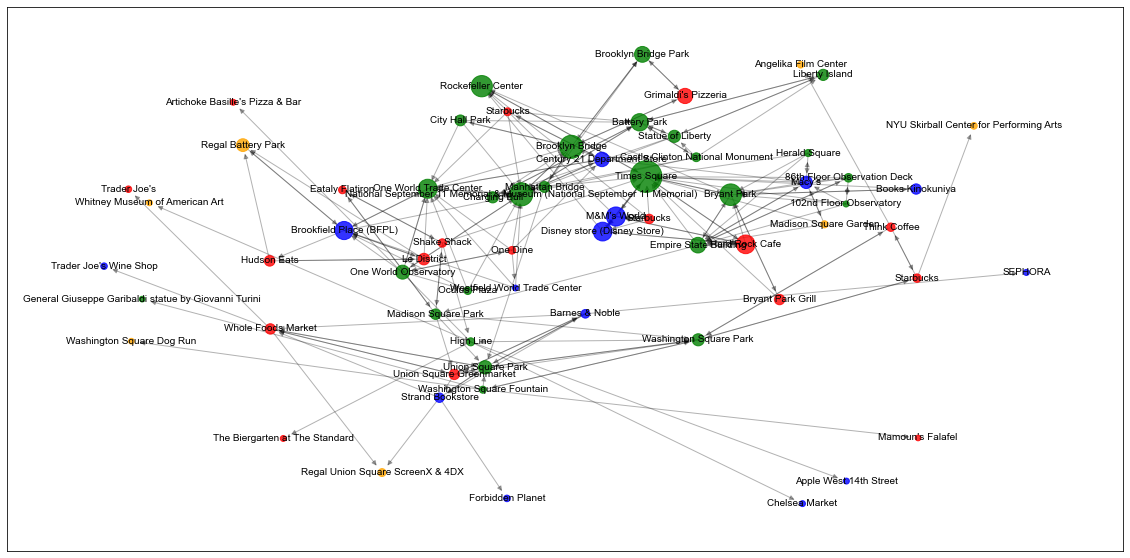

In [28]:
draw_network_with_colors()

The colored graph above shows that tourist attactions are the most important in the network, followed by stores. This is not suprising if you consider a typical tourist's NYC itinerary.

Both the shell and spectral graphs below help to show that the venues come three distinct neighborhoods (not immediately obvious without geographic knowledge of the area). The spectral graph in particular complements the top 5 betweenness table from above. There are one or two nodes in particular that link a neighborhood to the rest of the network.

### Shell graph

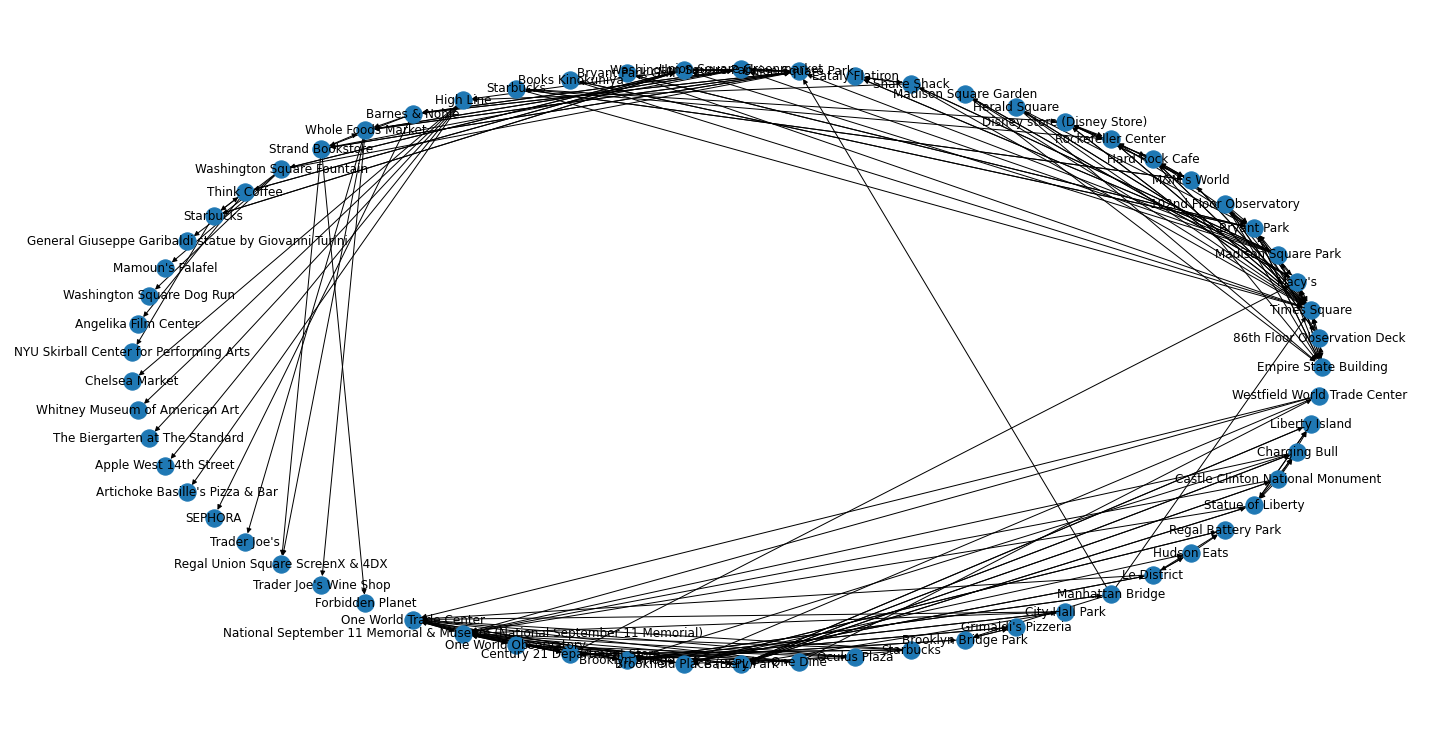

In [29]:
nx.draw_shell(g, labels=labels)

### Spectral graph

In [ ]:
nx.draw_spectral(g, k = 1.5, labels=labels)

## Conclusion

In summary, we generated a graph from based on visit links between three venues from three NYC neighborhoods. We calculated centrality measures both for the graph as a whole and for individual categories. Times Square is the most central venue in terms of importance, degree and closeness, however it is not as much of a boundary spanner node as its betweenness is less than Brooklyn Bridge. Using analysis of variance, we determined that centrality across categories of venues is different, except in terms of closeness - which indicates that, on average, nodes are equally close to all other nodes.

With the help of graph visualization, we determined that tourist attractions are the most important nodes in this (sampled and limited) network, followed by large stores. One application of this analysis could be to help a tourist create an itinerary of the most "important" venues, if one has only a limited time to visit NYC.  

In [31]:
# YouTube video link